In [1]:
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import arviz as az
import matplotlib.pyplot as plt
import theano.tensor as tt
%matplotlib inline

In [120]:
true = np.where(np.random.uniform(0,1,12)<0.5, 1, 0)
pred_score = 2*(true-0.5) + np.random.normal(0, 1.7, true.shape)

In [135]:
pop_sample = np.where(np.random.uniform(0,1,20000)<0.01, 1, 0)

In [136]:
pred = np.where(pred_score<0, 0, 1)

tp = np.sum(true * pred)
fp = np.sum((1-true) * pred)
    
with pm.Model() as model:
    
    
    b_tpr = pm.Beta("tpr", 0.5, 0.5)
    _tp = pm.Binomial("tp", n=sum(true), p=b_tpr, observed=tp)
    
    b_fpr = pm.Beta("fpr", 0.5, 0.5)
    _fp = pm.Binomial("fp", n=len(true)-sum(true), p=b_fpr, observed=fp)
    
    
    
    
    b_tnr = pm.Deterministic("tnr", 1-b_fpr)
    b_fnr = pm.Deterministic("fnr", 1-b_tpr)    
    b_npv = pm.Deterministic("npv", b_tnr / (b_tnr + b_fnr))
    b_ppv = pm.Deterministic("ppv", b_tpr / (b_tpr + b_fpr))
    b_fdr = pm.Deterministic("fdr", 1-b_ppv)
    b_for = pm.Deterministic("for", 1-b_npv)
    b_ba = pm.Deterministic("ba", (b_tpr+b_tnr)/2.0)
    b_acc = pm.Deterministic("acc", (b_tpr+b_tnr) / (b_tpr+b_tnr+b_fpr+b_fnr))
    
    b_base = pm.Beta("b_base", 0.5, 0.5)
    base = pm.Binomial("base", n=len(pop_sample), p=b_base, observed=np.sum(pop_sample))
    
    b_p_pos = pm.Deterministic("p_pos_and_pos", b_base * b_tpr / (b_base * b_tpr + (1-b_base) * b_fpr))
    b_p_neg = pm.Deterministic("p_neg_but_pos", b_base * b_fnr / (b_base * b_fnr + (1-b_base) * b_tnr))
    b_n_neg = pm.Deterministic("p_neg_and_neg", (1-b_base) * b_tnr / ((1-b_base) * b_tnr + (b_base) * b_fnr))
    b_n_pos = pm.Deterministic("p_pos_but_neg", (1-b_base) * b_fnr / ((1-b_base) * b_fnr + (b_base) * b_tnr))
        
    trace = pm.sample(1000, cores=1)    
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [b_base, fpr, tpr]
Sampling chain 1, 0 divergences: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:01<00:00, 967.73it/s]
The acceptance probability does not match the target. It is 0.885016452210529, but should be close to 0.8. Try to increase the number of tuning steps.


In [137]:
def logit(p):
    return 10 * np.log10(p / (1-p))

def inv_logit(p):
    q = p /10.0
    return (10**q)/(10**q+1)

In [138]:
az_trace = az.convert_to_dataset(trace)
az_trace_log = logit(az_trace)

(-30, 30)

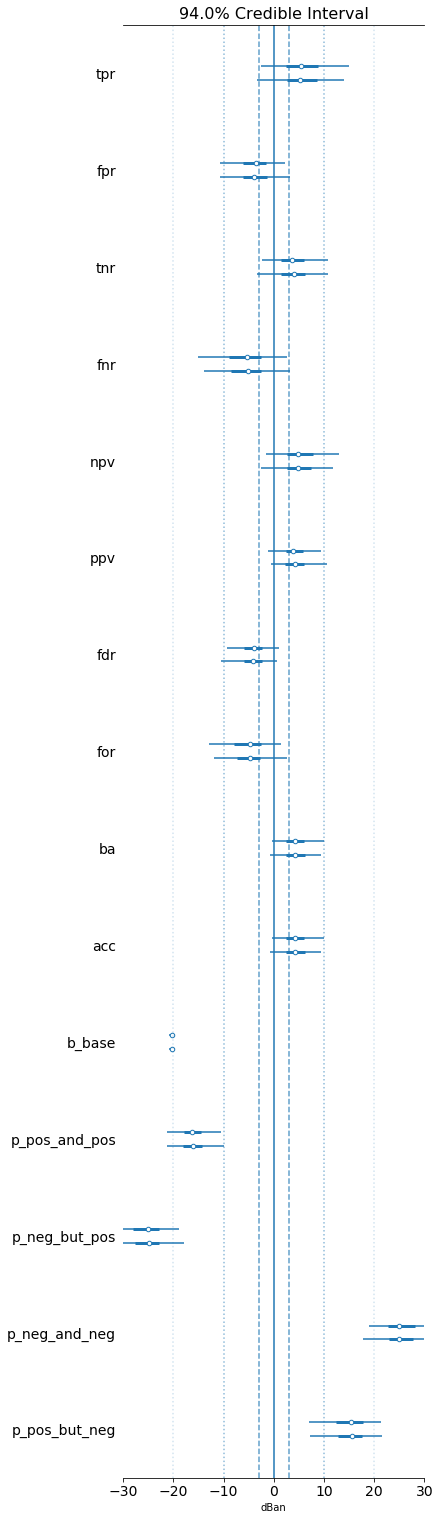

In [140]:
az.plot_forest(az_trace_log)
plt.axvline(0.0)    

plt.axvline(-10.0 * np.log10(2.0), ls="--", alpha=0.7)    
plt.axvline(10.0 * np.log10(2.0), ls="--",alpha=0.7)    
plt.axvline(-10.0, ls=":", alpha=0.5)    
plt.axvline(10.0, ls=":", alpha=0.5)    

plt.axvline(-20.0 , ls=":", alpha=0.2)    
plt.axvline(20.0 , ls=":", alpha=0.2)    
plt.xlabel("dBan")
plt.xlim(-30,30)